## Exp3 trial

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.autograd.functional import hessian
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm 
import pickle
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import os
import copy
from torch.nn.utils import _stateless

batch_size = 1
num_workers = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device

details = {}
details['use_db'] = 'mnist'
details['result_root_dir']='results/t0/'
details['result_path']='try1_t8_w9999'
# details['ratio'] = 15
details['book_keep_freq'] = 20
details['g_times'] = 8
details['g_epochs'] = 1
details['alpha_0']= 0.001
details['freq_reduce_by'] = 20
details['freq_reduce_after'] = 100

details['training_step_limit'] = 2000000 ## this is to train for max updates per epochs
details['stop_hess_computation'] = 1000000 ## Stop computing hessian after calculated these many times

details['g_weight'] = [9,9,9,9]
print(f'selected weight:{details["g_weight"]}')

with open(details['result_root_dir']+'details_'+details['result_path']+'.txt', 'w+') as f:
    for key, val in details.items():
        content = key + ' : '+str(val) + '\n'
        f.write(content)
        
torch.manual_seed(3407)
np.random.seed(3407)
torch.cuda.manual_seed_all(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# torch.use_deterministic_algorithms(True)
# os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:2"

train_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data_all = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)
# print(f'train data:{train_data}')
# print(f'test data:{test_data}')

def get_random_subset(train_data_all, test_data_all):    
    # train_indices = torch.arange(20000)
    test_indices = torch.arange(256)
    train_indices = torch.randint(60000-1, (2000,))
    # print(f'train indices:{train_indices[:10]}')
    train_data = data_utils.Subset(train_data_all, train_indices)
    test_data = data_utils.Subset(test_data_all, test_indices)
    # print(f'train data:{train_data}')
    # print(f'test data:{test_data}')
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    g = torch.Generator()
    g.manual_seed(0)

    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=256,
        num_workers=num_workers,
        worker_init_fn=seed_worker,
        generator=g,
    )
    print(f'train data size:{len(train_loader.dataset)}')
    print(f'test data size:{len(test_loader.dataset)}')
    # X_mat, y_mat = torch.Tensor(len(train_loader.dataset),784), torch.Tensor(len(train_loader.dataset)).long()
    # for i, (data, label) in enumerate(train_loader):
    #     X_mat[i] = data.flatten()
    #     y_mat[i] = label.flatten()
    # print(f'X_mat shape:{X_mat.shape}, y_mat shape:{y_mat.shape}')
    return train_loader, test_loader #, X_mat, y_mat


class Net(nn.Module):

    def __init__(self, input_features, hidden_layers, output_size):
        super(Net, self).__init__()
        self.layers = len(hidden_layers) + 1
        self.total_params_len = 0
        self.fc_layers = nn.ModuleList()
        prev_weight = input_features
        
        for i, weight in enumerate(hidden_layers):
            self.fc_layers.append(nn.Linear(prev_weight, weight))
            self.total_params_len += prev_weight*weight + weight
            prev_weight = weight
        
        self.fc_last = nn.Linear(hidden_layers[-1], output_size)
        self.total_params_len += hidden_layers[-1]*output_size + output_size
        
        ### Others required params
        self.param_list = []

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        # print('x shape in forward',x.shape)
        for fc_layer in self.fc_layers:
            x = F.relu(fc_layer(x))
        x = self.fc_last(x)
        return x
    
    def fit(self, X, Y, X_val, Y_val, epochs, batch_size=1, **kwargs):
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(self.parameters())
        

class Train_nn:
    
    def __init__(self, input_features, hidden_layers, output_size, lr):
        self.model = Net(input_features, hidden_layers=hidden_layers, output_size=output_size)
        self.model.to(device)
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=lr)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda= lambda it: 1/(it+1))
        
    def get_loss(self, X, y, params=None):
        # if params is not None:
        assert False, "Model not initialized with given params"
        op = self.model(X)
        loss = self.loss_fn(pred, y)
        return loss
    
    def get_gradient(self):
        params = (self.model.parameters())
        grad_norm_sq = torch.tensor(0, dtype=float).to(device)
        # print('grad Norm init:', grad_norm_sq)
        for param in self.model.parameters():
            temp = param.grad.data.pow(2).sum()
            # print(f'param grad norm \n\tsum:{temp.data}')#,\n\tshape:{param.shape}')
            grad_norm_sq += temp
            
        return grad_norm_sq.sqrt().cpu()
    
    def get_gradientv2(self, X, y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_grad(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        grad_mat = torch.autograd.grad(loss_fun_grad, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        grad_norm = torch.tensor(0.).to(device)
        for i in range(len(grad_mat)):
            for j in range(len(grad_mat[0])):
                grad_norm+= grad_mat[i][j].pow(2).sum()
        grad_norm = grad_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return grad_norm.cpu()
    
    def try_operator_norm(self, hess_mat):
        for i in len(hess_mat):
            for j in len(hess_mat[0]):
                torch.unsqueeze(hess_mat[i][i],0)
        hess_tensor_dim = list(hess_mat[0][0].shape)
        hess_tensor_dim += [n*2,n*2]
        hess_mat_np = np.zeros(shape=hess_tensor_dim)
        hess_tensor = torch.tensor(hess_mat_np)
        torch.cat(hess_mat, out=hess_tensor)
        
        hess_mat.reshpe(n*2,n*2)
        hess_norm = torch.linalg.norm(hess_mat, 2)
        assert False, "Not working"
    
    def get_hessian(self, X, y):
        prev_params = copy.deepcopy(list(self.model.parameters()))
        n = self.model.layers
        def local_model(*params):
            # print(f'len of params:{len(params)}')
            # print(f'shape of params[0]:{params[0].shape}')
            # with torch.no_grad():
            #initialize model with given params
            i = 0
            for i, param in enumerate(self.model.parameters()):
                param.data = params[i]
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            # print(f'loss type:{type(loss)}')
            return loss
        p =list(self.model.parameters())
        hess_mat = hessian(local_model, tuple(p))
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        
        # print(f'Hess mat len:{len(hess_mat)}')
        # print(f'Hess mat[0] len:{len(hess_mat[0])}')
        # print(f'Hess mat[0][0] shape:{hess_mat[0][0].shape}')
        
        hess_norm = hess_norm.sqrt()
        # print(f'hess norm:{hess_norm}')
        
        # Reinitialize the original params to model
        for i, param in enumerate(self.model.parameters()):
                param.data = prev_params[i]
        
        return hess_norm
    
    def get_hessianv2(self, X,y):
        names = list(n for n, _ in self.model.named_parameters())
        def loss_fun_hess(*params):
            out: torch.Tensor = _stateless.functional_call(self.model, {n: p for n, p in zip(names, params)}, X)
            local_loss = self.loss_fn(out, y)
            return local_loss
        hess_mat = hessian(loss_fun_hess, tuple(self.model.parameters()))
        # print(f'len of hess mat:{len(hess_mat)}')
        # print(f'hess_mat[0] shape:{len(hess_mat[0])}')
        # print(f'hess_mat[0][0] shape:{hess_mat[0][0].shape}')
        hess_norm = torch.tensor(0.).to(device)
        for i in range(len(hess_mat)):
            for j in range(len(hess_mat[0])):
                hess_norm+= hess_mat[i][j].pow(2).sum()
        hess_norm = hess_norm.sqrt()
        # print(f'v2 hess norm{hess_norm}')
        return hess_norm.cpu()
        
    def fit(self, train_loader, test_loader, epochs, store_grads=False, store_hessian=False, store_gen_err=False, store_weights=False, store_pt_loss=True, store_freq = 20, freq_reduce_by=None, freq_reduce_after=None):
        
        ## For Book keeping results ##
        self.grads_norms = []
        self.grads_normsv2 = []
        self.param_list = []
        self.hess_norms = []
        self.gen_err = []
        self.train_loss = []
        self.val_loss = []
        self.point_loss = []
        ## Initializing values ##
        terminate_training = False
        store_count = 0
        
        for epoch in tqdm(range(epochs), total=epochs, unit="epoch", disable=True):
            if terminate_training == True:
                break
            for batch, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader), unit='batch'):
                if batch>details['training_step_limit']:
                    terminate_training = True
                    break
                
                X, y =X.to(device), y.to(device)
                pred = self.model(X)
                loss = self.loss_fn(pred, y)

                # Backpropagation
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                ## Saving point loss
                if store_pt_loss and (batch%store_freq==0):
                    self.point_loss.append(loss.item())
                    
                ## Saving the weights
                if store_weights and (batch%store_freq==0):
                    current_params = tuple(self.model.parameters())
                    self.param_list.append(current_params)
                
                ## computing and saving the gradient
                if store_grads and (batch% store_freq == 0):
                    # store_count += 1
                    # # print(f'\tstore_freq:{store_freq}, batch:{batch}')
                    # if store_count%freq_reduce_after==0:
                    #     store_freq += freq_reduce_by
                    #     # print(f'store freq:{store_freq}, batch:{batch}')
                    grad_norm_per_update = self.get_gradient()
                    # print('\tgrad norm:', grad_norm_per_update)
                    self.grads_norms.append(grad_norm_per_update)
                    # self.grads_normsv2.append(self.get_gradientv2(X,y))
                ## computing and saving hessian
                if store_hessian and (batch% store_freq==0):
                    #assert False, "Not implemented"
                    self.optimizer.zero_grad()
                    self.hess_norms.append(self.get_hessianv2(X,y))
                    store_count += 1
                    if store_count%freq_reduce_after==0:
                        store_freq += freq_reduce_by
                
                ## computing and storing the generalization error
                if store_gen_err and (batch% store_freq == 0):
                    assert False, "fix reducing freq to get it working and fastX, fasty"
                    train_loss, test_loss, point_loss=0, 0, 0
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(train_loader):
                            # if sub_batch> batch: # only taking the encountered points to calculate train loss
                            #     break
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            train_loss += self.loss_fn(pred_local, y_local).item()
                    train_loss = train_loss/(batch+1)
                    with torch.no_grad():
                        for sub_batch, (X_local,y_local) in enumerate(test_loader):
                            X_local, y_local = X_local.to(device), y_local.to(device)
                            pred_local = self.model(X_local)
                            test_loss += self.loss_fn(pred_local, y_local).item()
                    test_batch_size = len(test_loader)
                    # print(f"Number of batches in test:{len(test_loader)}")
                    test_loss = test_loss/ len(test_loader)
                    self.train_loss.append(train_loss)
                    self.val_loss.append(test_loss)
                
                if batch % 10000 == 9999:
                    loss, current = loss.item(), batch * len(X)
                    correct = 0
                    test_loss = 0
                    with torch.no_grad():
                        for X, y in test_loader:
                            X, y = X.to(device), y.to(device)
                            pred = self.model(X)
                            test_loss += self.loss_fn(pred, y).item()
                            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
                    acc = 100*correct/len(test_loader.dataset)
                    print(f"\taccuracy:{acc}")#, at batch:{batch}")
                    print(f"\tloss: {loss:>7f}")
                
                    # print(f'Learning rate:{self.scheduler.get_last_lr()}')
                self.scheduler.step()
            
def exp_get_lp_sm(train_data_all, test_data_all, op_features, weight = 10, times = 8, epochs = 1, root_dir='', path=None, clear_file = True, freq_reduce_by=10, freq_reduce_after=100):
    grad_list        = []
    hess_norm_list   = []
    if path is not None:
        grad_file_path = root_dir+'grad_'+path
        hess_file_path = root_dir+'hess_'+path
        # gen_file_path = root_dir+'gen_'+path
        if clear_file:
            with open(grad_file_path, 'w+') as f:
                f.write('')
            with open(hess_file_path, 'w+') as f:
                f.write('')
    
    train_loader, test_loader = get_random_subset(train_data_all, test_data_all)
    for t in range(times):
        print(f'Time:{t}')
        train_model = Train_nn(784, weight, op_features, lr= details['alpha_0'])
        train_model.fit(train_loader, test_loader, epochs=epochs, store_grads=True, store_hessian=True, store_freq=details['book_keep_freq'],  store_gen_err=False, store_pt_loss=False, store_weights=False, freq_reduce_by = freq_reduce_by, freq_reduce_after=freq_reduce_after, )
        
        with open(grad_file_path,'a+') as f:
            f.write(' '.join([str(grad) for grad in train_model.grads_norms]) + '\n')
        with open(hess_file_path,'a+') as f:
            f.write(' '.join([str(hess) for hess in train_model.hess_norms]) + '\n')
        
        hess_norm_list.append(train_model.hess_norms)
        grad_list.append(train_model.grads_norms)
         
    return grad_list, hess_norm_list

grad_list, hess_norm_list = exp_get_lp_sm(train_data_all, test_data_all, op_features=10, 
              weight=details['g_weight'], times=details['g_times'], 
              epochs=details['g_epochs'], root_dir=details['result_root_dir'], 
              path=details['result_path'], freq_reduce_by=details['freq_reduce_by'], 
              freq_reduce_after=details['freq_reduce_after'])


selected weight:[9, 9, 9, 9]
train data size:2000
test data size:256
Time:0


  0%|          | 0/2000 [00:00<?, ?batch/s]

KeyboardInterrupt: 

## Plot results

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
def get_exp_details(root_dir, path):
    result_details={}
    details_path = root_dir+ 'details_'+ path + '.txt'
    with open(details_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        key, val = line[:-1].split(':')
        key, val = key.strip(' '), val.strip(' ')
        if key in ['ratio', 'alpha_0']:
            val = float(val)
        if key in ['Times', 'Weights', 'Epochs', 'book_keep_freq', 'g_times', 'g_epochs', 'freq_reduce_by', 'freq_reduce_after']:
            val = int(val)
        elif key in ['g_weight']:
            print('weight:', val)
            val = [int(t) for t in val[1:-1].split(', ')]
        result_details[key] = val
    return result_details

def get_exp_results(r_det, train_size=20000):
    root_dir = r_det['result_root_dir']
    path = r_det['result_path']
    grad_file_path = root_dir+'grad_'+path
    hess_file_path = root_dir+'hess_'+path
    gen_file_path  = root_dir+'gen_'+path
    
    # print(result_details)
    grad_list    = []
    hess_list    = []
    gen_err_list = []
    
    with open(grad_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(') ')
        # print('tensors',tensors)
        t_list = [float(t[7:].split(' ')[0][:-1]) for t in tensors]
        # print('grad_list_i length:',len(t_list))
        grad_list.append(t_list)
    
    with open(hess_file_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        tensors = line[:-1].split(' ')
        # print('tensors',tensors)
        t_list = [float(t[7:-1]) for t in tensors]
        # print('hess_list_i length:',len(t_list))
        hess_list.append(t_list)
    hess_list = np.array(hess_list)
    grad_list = np.array(grad_list)
    print('hess list shape:',hess_list.shape)
    print('grad list shape:',grad_list.shape)
    K_g = np.max(np.mean(np.array(grad_list), 0))
    L_g = np.max(np.mean(np.array(hess_list), 0))
    
    book_keep_freq = r_det['book_keep_freq']
    freq_reduce_after = r_det['freq_reduce_after']
    freq_reduce_by = r_det['freq_reduce_by']
    x_values = []
    count_keep = 0
    for i in range(train_size):
        if i%book_keep_freq==0:
            x_values.append(i+1)
            count_keep+=1
            if count_keep%freq_reduce_after==0:
                book_keep_freq+=freq_reduce_by
    
    return grad_list, hess_list, K_g, L_g, x_values

def plot_exp_data(root_dir_list, path_list, weights_list, save_fig=False, train_size=20000):
    grad_mean_list = []
    grad_df_list = []
    grad_err_list  = []
    hess_mean_list = []
    hess_df_list = []
    hess_err_list  = []
    data = {}
    x_values = []
    for root_dir, path, weights in zip(root_dir_list, path_list, weights_list):

        res_details = get_exp_details(root_dir, path)
        grad_list, hess_list, K_g, L_g, x_values = get_exp_results(res_details, train_size)
        grad_list_m = np.max(grad_list,1)
        hess_list_m = np.max(hess_list,1)
        # K_g = np.percentile(np.mean(grad_list, 0),90)
        # L_g = np.percentile(np.mean(hess_list, 0),90)
        
        # K_g = np.max(np.mean(grad_list, 1))
        # L_g = np.max(np.mean(hess_list, 1))
        # print('grad_list shape',grad_list_m.shape)
        # print('grad_list ',grad_list_m)
        # print(f'K_g:{K_g}, L_g:{L_g}')
        grad_mean, grad_err = np.mean(grad_list_m), np.std(grad_list_m)
        hess_mean, hess_err = np.mean(hess_list_m), np.std(hess_list_m)
        grad_mean_list.append(grad_mean)
        grad_err_list.append(grad_err)
        hess_mean_list.append(hess_mean)
        hess_err_list.append(hess_err)
        params_size = 784
        for weight in weights:
            params_size*= weight
        x_values.append(str(params_size))
        for run_id in range(len(grad_list)):
            for epoch in range(len(grad_list[run_id])):
                grad_df_list.append({'key':int(params_size), 'run_id': run_id, 'epoch':epoch, 'val': grad_list[run_id][epoch]})
                                      
        for run_id in range(len(hess_list)):
            for epoch in range(len(hess_list[run_id])):
                hess_df_list.append({'key':int(params_size), 'run_id': run_id, 'epoch':epoch, 'val': hess_list[run_id][epoch]})
        
        # plt.errorbar(x_values, np.mean(grad_list,0),np.std(grad_list,0), label='ratio:'+str(ratio))
    df1 = pd.DataFrame(grad_df_list)
    df2 = pd.DataFrame(hess_df_list)
    
    temp_df1 = df1.groupby(['key','run_id'])['val'].max().reset_index()
    temp_df2 = df2.groupby(['key','run_id'])['val'].max().reset_index()
    # temp_df1 = df1
    # temp_df2 = df2
    grad_mean_list = np.array(grad_mean_list)
    grad_err_list = np.array(grad_err_list)
    hess_mean_list = np.array(hess_mean_list)
    hess_err_list = np.array(hess_err_list)
    # x_values = [str(int(train_size*t)) for t in ratios]
    fig, ax = plt.subplots(figsize=(12,7))
    sns.pointplot(data = temp_df1, x='key',y='val', estimator=np.mean, ax=ax, label='Lipschitz const.', color='orange', errwidth=0)
    ax.fill_between(x_values, grad_mean_list-grad_err_list, grad_mean_list+ grad_err_list, color='orange', alpha=.3)
    plt.xlabel('Number of parameters', fontsize = 24)
    plt.ylabel('Lipschitz constant', fontsize = 24)    
    sns.set_context("talk")
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": 2, "lines.markersize":10})
    plt.title('Mnist dataset', fontsize=24)
    if save_fig:
        plt.savefig('e3_Lipschitz_constant_mnist.png')
    
    fig, ax = plt.subplots(figsize=(12,7))
    sns.pointplot(data = temp_df2, x='key',y='val', ax=ax, label='Smoothness const.', color='green', errwidth=0)
    ax.fill_between(x_values, hess_mean_list-hess_err_list, hess_mean_list+ hess_err_list, color='green', alpha=.3)
    plt.xlabel('Number of parameters', fontsize = 24)
    plt.ylabel('Smoothness constant', fontsize = 24)    
    sns.set_context("talk")
    sns.set(font='sans-serif', style='whitegrid', font_scale=2, rc={"lines.linewidth": 2, "lines.markersize":10})
    # plt.show()
    plt.title('Mnist dataset', fontsize=24)
    if save_fig:
        plt.savefig('e3_Smoothness_constant_mnist.png')
    return df1, df2

weight: [9, 9, 9]
hess list shape: (8, 100)
grad list shape: (8, 100)
weight: [9, 9, 9, 9]
hess list shape: (8, 100)
grad list shape: (8, 100)
weight: [9, 9, 9, 9, 9]
hess list shape: (8, 100)
grad list shape: (8, 100)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

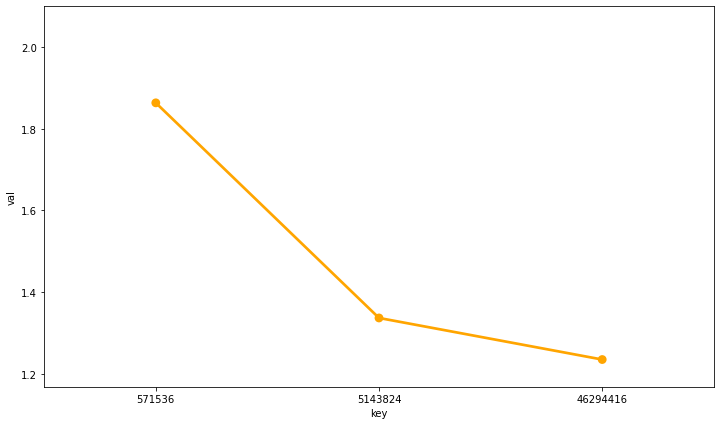

In [7]:
root_dir_list = ['results/t1/','results/t1/','results/t1/','results/t1/','results/t1/']
path_list = ['try1_t8_w999', 'try1_t8_w9999', 'try1_t8_w99999']
ratios = [1.0, 2.5, 5.0, 7.5, 10.0]
weights = [[9,9,9], [9,9,9,9], [9,9,9,9,9]]
grad_df, hess_f= plot_exp_data(root_dir_list[:3], path_list[:], weights[:], save_fig=False, train_size=2000)

In [14]:
np.mean(np.max(np.array(grad_list),1))
# for grad_list_1 in grad_list:
#     print(grad_list_1)

1.9654996227799617

In [11]:
for grad_list_1 in grad_list:
    print(grad_list_1)

[tensor(1.3310, dtype=torch.float64), tensor(1.6456, dtype=torch.float64)]
[tensor(1.9846, dtype=torch.float64), tensor(1.7699, dtype=torch.float64)]
[tensor(1.8806, dtype=torch.float64), tensor(2.1590, dtype=torch.float64)]
[tensor(1.9023, dtype=torch.float64), tensor(2.2948, dtype=torch.float64)]
[tensor(1.9634, dtype=torch.float64), tensor(1.7891, dtype=torch.float64)]
[tensor(1.8968, dtype=torch.float64), tensor(2.2273, dtype=torch.float64)]
[tensor(1.9494, dtype=torch.float64), tensor(2.4226, dtype=torch.float64)]
[tensor(1.7676, dtype=torch.float64), tensor(1.6867, dtype=torch.float64)]


In [15]:
1.645+1.9846+2.1590+2.2948+1.9634+2.2273+1.7676

14.041699999999999

In [7]:
hess_norm_list

[[tensor(26.4066), tensor(22.3224)],
 [tensor(33.6504), tensor(15.7732)],
 [tensor(31.5590), tensor(25.5066)],
 [tensor(29.2283), tensor(22.7296)],
 [tensor(36.8180), tensor(24.5703)],
 [tensor(28.2731), tensor(21.5612)],
 [tensor(34.9414), tensor(28.8288)],
 [tensor(27.7194), tensor(20.4769)]]